In [5]:
%%time
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, make_scorer
from scipy.stats import skew
from scipy.stats import norm
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("all"))
train = df_train =  pd.read_csv('all/train_V2.csv')
df_test = pd.read_csv('all/test_V2.csv')
# Any results you write to the current directory are saved as output.

['sample_submission_V2.csv', 'test_V2.csv', 'train_V2.csv']
Wall time: 2min 53s


In [6]:
df_train.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,...,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,...,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,...,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,...,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,...,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875


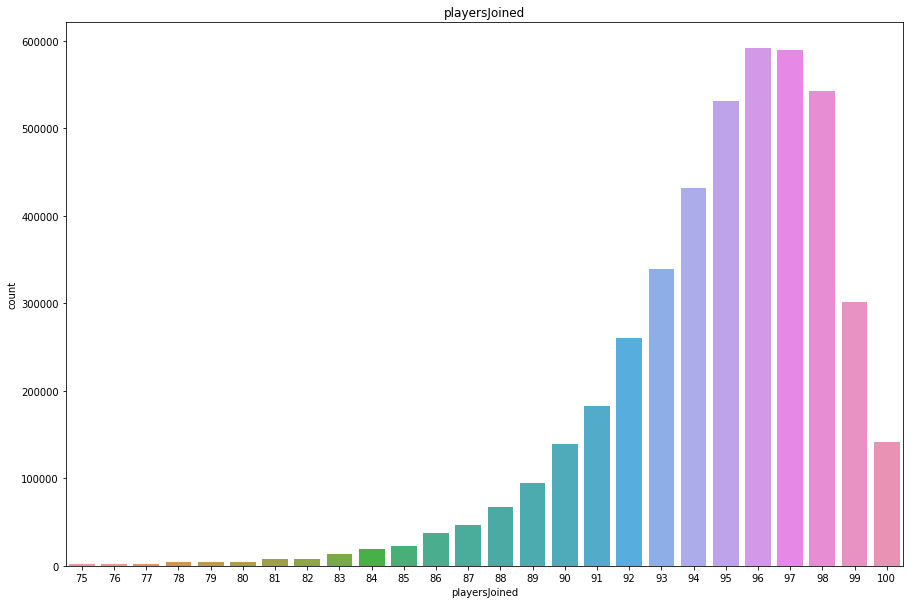

In [7]:
# playersJoined
df_train['playersJoined'] = df_train.groupby('matchId')['matchId'].transform('count')
plt.figure(figsize=(15,10))
sns.countplot(df_train[df_train['playersJoined']>=75]['playersJoined'])
plt.title('playersJoined')
plt.show()

In [8]:
# Create normalized features
df_train['killsNorm'] = df_train['kills']*((100-df_train['playersJoined'])/100 + 1)
df_train['damageDealtNorm'] = df_train['damageDealt']*((100-df_train['playersJoined'])/100 + 1)
df_train['maxPlaceNorm'] = df_train['maxPlace']*((100-df_train['playersJoined'])/100 + 1)
df_train['matchDurationNorm'] = df_train['matchDuration']*((100-df_train['playersJoined'])/100 + 1)
# Compare standard features and normalized features
to_show = ['Id', 'kills','killsNorm','damageDealt', 'damageDealtNorm', 'maxPlace', 'maxPlaceNorm', 'matchDuration', 'matchDurationNorm']
df_train[to_show][0:11]

,Id,kills,killsNorm,damageDealt,damageDealtNorm,maxPlace,maxPlaceNorm,matchDuration,matchDurationNorm
0,7f96b2f878858a,0,0.00,0.000,0.00000,28,29.12,1306,1358.24
1,eef90569b9d03c,0,0.00,91.470,99.70230,26,28.34,1777,1936.93
2,1eaf90ac73de72,0,0.00,68.000,69.36000,50,51.00,1318,1344.36
3,4616d365dd2853,0,0.00,32.900,35.86100,31,33.79,1436,1565.24
4,315c96c26c9aac,1,1.03,100.000,103.00000,97,99.91,1424,1466.72
5,ff79c12f326506,1,1.05,100.000,105.00000,28,29.40,1395,1464.75
6,95959be0e21ca3,0,0.00,0.000,0.00000,28,28.84,1316,1355.48
7,311b84c6ff4390,0,0.00,8.538,8.87952,96,99.84,1967,2045.68
8,1a68204ccf9891,0,0.00,51.600,53.14800,28,28.84,1375,1416.25
9,e5bb5a43587253,0,0.00,37.270,38.38810,29,29.87,1930,1987.90


In [9]:
# Create new feature healsandboosts
df_train['healsandboosts'] = df_train['heals'] + df_train['boosts']
df_train[['heals', 'boosts', 'healsandboosts']].tail()

,heals,boosts,healsandboosts
4446961,0,0,0
4446962,0,1,1
4446963,0,0,0
4446964,2,4,6
4446965,1,2,3


In [10]:
# Create feature totalDistance
df_train['totalDistance'] = df_train['rideDistance'] + df_train['walkDistance'] + df_train['swimDistance']
# Create feature killsWithoutMoving
df_train['killsWithoutMoving'] = ((df_train['kills'] > 0) & (df_train['totalDistance'] == 0))

In [11]:
# Create headshot_rate feature
df_train['headshot_rate'] = df_train['headshotKills'] / df_train['kills']
df_train['headshot_rate'] = df_train['headshot_rate'].fillna(0)

In [12]:
# Check players who kills without moving
display(df_train[df_train['killsWithoutMoving'] == True].shape)
df_train[df_train['killsWithoutMoving'] == True].head(10)

(1535, 38)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,winPlacePerc,playersJoined,killsNorm,damageDealtNorm,maxPlaceNorm,matchDurationNorm,healsandboosts,totalDistance,killsWithoutMoving,headshot_rate
1824,b538d514ef2476,0eb2ce2f43f9d6,35e7d750e442e2,0,0,593.00,0,0,3,18,...,0.8571,58,8.52,842.0600,21.30,842.06,3,0.0,True,0.000000
6673,6d3a61da07b7cb,2d8119b1544f87,904cecf36217df,2,0,346.60,0,0,6,33,...,0.6000,42,4.74,547.6280,17.38,2834.52,6,0.0,True,0.000000
11892,550398a8f33db7,c3fd0e2abab0af,db6f6d1f0d4904,2,0,1750.00,0,4,5,3,...,0.8947,21,35.80,3132.5000,35.80,1607.42,5,0.0,True,0.200000
14631,58d690ee461e9d,ea5b6630b33d67,dbf34301df5e53,0,0,157.80,0,0,0,69,...,0.0000,73,1.27,200.4060,24.13,1014.73,0,0.0,True,0.000000
15591,49b61fc963d632,0f5c5f19d9cc21,904cecf36217df,0,0,100.00,0,1,0,37,...,0.3000,42,1.58,158.0000,17.38,2834.52,0,0.0,True,1.000000
20881,40871bf43ddac7,2cea046b7d1dce,0600f86f11c6e4,0,0,506.10,4,1,3,7,...,0.8000,44,9.36,789.5160,9.36,909.48,3,0.0,True,0.166667
23298,b950836d0427da,1f735b1e00d549,ad860f4e162bbc,1,0,1124.00,0,4,1,7,...,0.6000,48,18.24,1708.4800,9.12,836.00,1,0.0,True,0.333333
24640,aeced11d46de19,d4009ffa95bb4f,73f3ed869c9171,2,0,529.90,0,2,11,12,...,0.8571,57,10.01,757.7570,21.45,856.57,11,0.0,True,0.285714
25659,6626c4d47cffa0,ee3fe5c0d917c3,341341834b7941,0,1,128.90,0,1,6,53,...,0.2857,61,2.78,179.1710,11.12,1017.48,7,0.0,True,0.500000
30079,869331b90bfa3f,869ea3ad036e53,fa373e28ff5062,0,0,85.56,0,0,0,46,...,0.8571,53,1.47,125.7732,22.05,1051.05,0,0.0,True,0.000000


In [13]:
# Remove outliers
df_train.drop(df_train[df_train['killsWithoutMoving'] == True].index, inplace=True)

In [55]:
# Players who got more than 30 kills
display(df_train[df_train['kills'] > 30].shape)
df_train[df_train['kills'] > 30].head(10)

(95, 34)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,playersJoined,healsandboosts,totalDistance,killsWithoutMoving,headshot_rate
57978,9d8253e21ccbbd,ef7135ed856cd8,37f05e2a01015f,9,0,3725.0,0,7,0,2,1000,35,3,105.80,1798,normal-duo-fpp,8,7,-1,0,0.0,0,0.0,0,0,48.82,48,1500,0.8571,16,0,48.82,False,0.200000
87793,45f76442384931,b3627758941d34,37f05e2a01015f,8,0,3087.0,0,8,27,3,1000,31,3,95.34,1798,normal-duo-fpp,8,7,-1,0,0.0,0,0.0,0,0,780.70,45,1500,1.0000,16,27,780.70,False,0.258065
156599,746aa7eabf7c86,5723e7d8250da3,f900de1ec39fa5,21,0,5479.0,0,12,7,4,0,48,6,81.95,1798,normal-solo-fpp,11,11,1500,0,0.0,0,0.0,0,0,23.71,61,0,0.7000,11,7,23.71,False,0.250000
160254,15622257cb44e2,1a513eeecfe724,db413c7c48292c,1,0,4033.0,0,40,0,1,1000,42,5,266.20,844,normal-squad-fpp,8,8,-1,0,0.0,0,0.0,1,0,718.30,16,1500,1.0000,62,0,718.30,False,0.952381
180189,1355613d43e2d0,f863cd38c61dbf,39c442628f5df5,5,0,3171.0,0,6,15,1,0,35,3,102.50,1796,normal-solo-fpp,9,6,1500,0,0.0,0,0.0,0,0,71.51,41,0,1.0000,11,15,71.51,False,0.171429
334400,810f2379261545,7f3e493ee71534,f900de1ec39fa5,20,0,6616.0,0,13,5,1,0,65,7,73.90,1798,normal-solo-fpp,11,11,1500,0,0.0,0,0.0,0,0,1036.00,60,0,1.0000,11,5,1036.00,False,0.200000
353128,f3e9746e3ff151,4bc1f00f07b304,a9e84c456cc859,2,0,3834.0,0,9,5,1,0,39,3,263.90,1795,normal-solo-fpp,13,10,1500,0,0.0,0,0.0,0,0,124.20,42,0,1.0000,13,5,124.20,False,0.230769
457829,265e23756baa0b,9d94424171c2a1,664dee9ed8f646,3,0,2907.0,0,27,2,1,0,33,4,439.20,827,normal-squad,5,5,1500,0,0.0,0,0.0,1,0,382.40,15,0,1.0000,38,2,382.40,False,0.818182
488335,31a0682922ef45,275a27a3ee4cc8,3037f74ef8a3a3,2,0,3055.0,0,9,0,1,1000,33,5,97.99,892,normal-solo-fpp,18,14,-1,0,0.0,0,0.0,0,0,35.30,31,1500,1.0000,20,0,35.30,False,0.272727
662650,dd424a8b74bd49,ac9dea6d62f2e6,8a728def0644be,9,0,3454.0,38,9,4,1,1000,34,4,124.00,1198,normal-squad-fpp,14,14,-1,0,0.0,0,0.0,0,0,111.10,25,1500,0.2308,54,4,111.10,False,0.264706


In [14]:
# Remove outliers
df_train.drop(df_train[df_train['kills'] > 30].index, inplace=True)

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


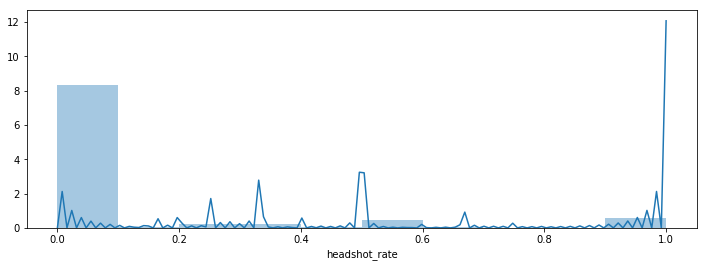

In [57]:
# Plot the distribution of headshot_rate
plt.figure(figsize=(12,4))
sns.distplot(df_train['headshot_rate'], bins=10)
plt.show()

In [58]:
display(df_train[(df_train['headshot_rate'] == 1) & (df_train['kills'] > 9)].shape)
df_train[(df_train['headshot_rate'] == 1) & (df_train['kills'] > 9)].head(10)

(24, 34)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,playersJoined,healsandboosts,totalDistance,killsWithoutMoving,headshot_rate
281570,ab9d7168570927,add05ebde0214c,e016a873339c7b,2,3,1212.0,8,10,0,1,0,10,4,159.20,1423,squad-fpp,27,25,1564,1,0.0,0,0.0,0,0,2939.0,5,0,0.8462,93,3,2939.0,False,1.0
346124,044d18fc42fc75,fc1dbc2df6a887,628107d4c41084,3,5,1620.0,13,11,3,1,1424,11,2,633.60,1727,squad,27,26,-1,3,4720.0,0,0.0,0,0,3422.0,8,1560,1.0000,96,8,8142.0,False,1.0
871244,e668a25f5488e3,5ba8feabfb2a23,f6e6581e03ba4f,0,4,1365.0,9,13,0,1,1579,13,2,353.80,1255,squad,27,27,-1,0,0.0,0,0.0,0,0,2105.0,5,1587,1.0000,98,4,2105.0,False,1.0
908815,566d8218b705aa,a9b056478d71b2,3a41552d553583,2,5,1535.0,10,10,3,1,1393,10,3,533.20,1838,squad-fpp,28,24,-1,0,5187.0,0,0.0,2,0,2761.0,7,1519,0.9630,95,8,7948.0,False,1.0
963463,1bd6fd288df4f0,90584ffa22fe15,ba2de992ec7bb8,2,6,1355.0,12,10,2,1,1543,10,2,277.00,1417,squad,27,26,-1,0,1018.0,0,0.0,0,0,2458.0,4,1562,1.0000,96,8,3476.0,False,1.0
1079403,1c245ed99b5f96,e42d09a9b8463a,5cec236bce68eb,0,5,1218.0,8,11,3,1,0,11,3,484.90,1821,squad-fpp,28,27,1495,0,5246.0,0,0.0,0,0,2932.0,4,0,1.0000,95,8,8178.0,False,1.0
1167959,c4f80d4be5c561,b4a7892189b5dd,c7f7733ebbd447,0,4,1065.0,6,10,1,1,1391,10,2,222.00,1246,squad-fpp,27,27,-1,0,408.9,0,0.0,0,0,2450.0,7,1468,1.0000,97,5,2858.9,False,1.0
1348164,474a641f0a4bcb,2fdad3ca6fb3c0,114499c82f35d7,1,5,1319.0,11,12,1,1,0,12,2,443.00,1730,squad-fpp,28,28,1560,0,2048.0,0,0.0,0,0,3915.0,5,0,1.0000,93,6,5963.0,False,1.0
1380385,202ce6a55119c5,2df66861f597b4,496700c29a5d44,1,4,1150.0,4,11,1,1,1000,11,3,289.60,1248,duo,46,41,0,1,0.0,0,0.0,0,0,3108.0,7,1500,1.0000,88,5,3108.0,False,1.0
1483199,9d483f7cbb34d4,db5867bc814191,69495e3c478eb9,0,10,1478.0,8,13,2,1,0,13,3,95.14,1379,duo-fpp,49,48,1813,0,0.0,0,140.8,0,0,2339.0,4,0,1.0000,96,12,2479.8,False,1.0


/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


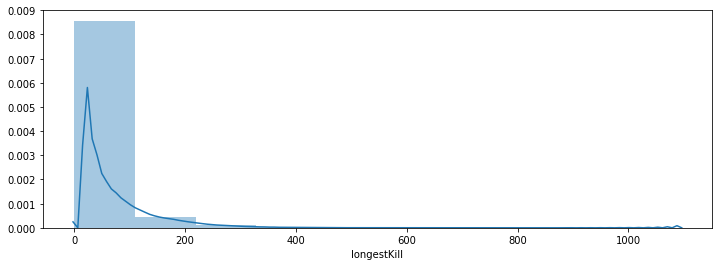

In [59]:
# Plot the distribution of longestKill
plt.figure(figsize=(12,4))
sns.distplot(df_train['longestKill'], bins=10)
plt.show()

In [60]:
# Check out players who made kills with a distance of more than 1 km
display(df_train[df_train['longestKill'] >= 1000].shape)
df_train[df_train['longestKill'] >= 1000].head(10)

(20, 34)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,playersJoined,healsandboosts,totalDistance,killsWithoutMoving,headshot_rate
202281,88e2af7d78af5a,34ddeede52c042,4346bc63bc67fa,0,3,783.9,5,1,1,5,0,4,3,1000.0,1864,squad,27,27,1482,0,723.2,0,0.0,0,1,3052.00,9,0,0.9231,88,4,3775.20,False,0.250000
240005,41c2f5c0699807,9faecf87ab4275,634edab75860b3,5,0,1284.0,8,5,7,18,1000,11,2,1004.0,1308,normal-duo-fpp,14,13,-1,1,0.0,0,0.0,0,0,48.87,38,1500,0.5385,29,7,48.87,False,0.454545
324313,ef390c152bcc3d,30fd444be3bbc1,4f7f8d6cf558b4,2,0,1028.0,0,0,0,9,0,10,2,1026.0,698,normal-squad-fpp,13,13,1500,0,1717.0,0,0.0,0,0,1264.00,26,0,1.0000,51,0,2981.00,False,0.000000
656553,9948b058562163,c8cb8491112bf6,0104eeb664494d,6,0,1410.0,17,5,0,3,1000,16,4,1000.0,1091,normal-squad-fpp,6,6,-1,4,0.0,0,0.0,0,0,29.21,30,1500,0.6000,41,0,29.21,False,0.312500
803632,4e7e6c74e3c57d,94698690918933,da91b0c3d875f8,0,0,196.8,0,0,0,51,0,1,1,1075.0,471,normal-squad-fpp,8,8,1500,0,2085.0,0,0.0,0,0,1074.00,22,0,0.0000,61,0,3159.00,False,0.000000
895411,1f5ba6e0cfb968,512ea24b831be3,5fb0d8b1fc16cf,4,0,1012.0,11,5,0,5,0,10,3,1094.0,1021,normal-squad-fpp,12,12,1500,0,0.0,0,0.0,0,0,569.50,18,0,0.9091,86,0,569.50,False,0.500000
1172437,303a93cfa1f46c,8795d39fd0df86,9c8962b58bb3e3,2,1,329.3,0,0,2,45,1000,3,1,1037.0,581,normal-squad-fpp,8,7,-1,0,0.0,0,0.0,0,0,832.50,9,1500,0.2857,58,3,832.50,False,0.000000
1209416,528659ff1c1aec,7d1ba83423551d,ea9386587d5888,0,6,1640.0,0,7,0,1,1000,15,2,1001.0,1235,solo,52,51,-1,0,0.0,0,0.0,0,0,2848.00,4,1500,0.9412,52,6,2848.00,False,0.466667
1642712,91966848e08e2f,0ee4fbd27657c9,17dea22cefe62a,3,2,2103.0,0,4,11,11,0,23,2,1005.0,1798,normal-duo-fpp,15,12,1500,0,0.0,0,0.0,0,0,235.30,41,0,0.5000,28,13,235.30,False,0.173913
2015559,5ff0c1a9fab2ba,2d8119b1544f87,904cecf36217df,3,3,1302.0,0,6,5,15,0,11,2,1037.0,1794,normal-squad-fpp,11,11,1500,0,0.0,0,0.0,0,0,133.20,43,0,0.6000,42,8,133.20,False,0.545455


In [15]:
# Remove outliers
df_train.drop(df_train[df_train['longestKill'] >= 1000].index, inplace=True)

In [62]:
# Summary statistics for the Distance features
df_train[['walkDistance', 'rideDistance', 'swimDistance', 'totalDistance']].describe()

,walkDistance,rideDistance,swimDistance,totalDistance
count,4.445316e+06,4.445316e+06,4.445316e+06,4.445316e+06
mean,1.154628e+03,6.063296e+02,4.510974e+00,1.765469e+03
std,1.183514e+03,1.498571e+03,3.050771e+01,2.183260e+03
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.554000e+02,0.000000e+00,0.000000e+00,1.584000e+02
50%,6.864000e+02,0.000000e+00,0.000000e+00,7.893000e+02
75%,1.977000e+03,2.609750e-01,0.000000e+00,2.729000e+03
max,2.578000e+04,4.071000e+04,3.823000e+03,4.127010e+04


/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


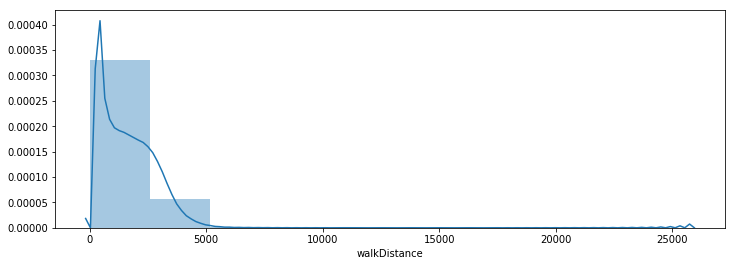

In [63]:
# Plot the distribution of walkDistance
plt.figure(figsize=(12,4))
sns.distplot(df_train['walkDistance'], bins=10)
plt.show()

In [64]:
# walkDistance anomalies
display(df_train[df_train['walkDistance'] >= 10000].shape)
df_train[df_train['walkDistance'] >= 10000].head(10)

(219, 34)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,playersJoined,healsandboosts,totalDistance,killsWithoutMoving,headshot_rate
23026,8a6562381dd83f,23e638cd6eaf77,b0a804a610e9b0,0,1,0.00,0,0,0,44,0,0,0,0.000,1906,solo,99,93,1517,0,0.4212,0,9.882,0,0,13530.0,7,0,0.8163,99,1,13540.3032,False,0.0
34344,5a591ecc957393,6717370b51c247,a15d93e7165b05,0,3,23.22,0,0,1,34,1256,0,0,0.000,1977,squad-fpp,20,20,-1,0,0.0373,0,40.870,0,0,10030.0,7,1533,0.9474,65,4,10070.9073,False,0.0
49312,582685f487f0b4,338112cd12f1e7,d0afbf5c3a6dc9,0,4,117.20,1,0,1,24,0,1,1,6.823,2192,duo-fpp,47,46,1507,0,0.0088,0,36.750,0,0,12410.0,3,0,0.9130,94,5,12446.7588,False,0.0
68590,8c0d9dd0b4463c,c963553dc937e9,926681ea721a47,0,1,32.34,0,0,1,46,1378,0,0,0.000,1836,duo-fpp,49,47,-1,0,847.8000,0,45.820,0,0,11590.0,3,1563,0.8333,96,2,12483.6200,False,0.0
94400,d441bebd01db61,7e179b3366adb8,923b57b8b834cc,1,1,73.08,0,0,3,27,1000,0,0,0.000,1806,solo,73,64,-1,0,1005.0000,0,45.630,0,0,10440.0,6,1488,0.8194,73,4,11490.6300,False,0.0
125103,db5a0cdc969dcb,50cc466757950e,c306a9745c4c1d,0,4,37.73,0,0,7,47,1000,0,0,0.000,1957,solo,95,93,-1,0,0.0378,0,38.760,0,0,12790.0,5,1500,0.7340,95,11,12828.7978,False,0.0
136421,955e60b09a96b1,30df08fe22a901,8669d01725f135,0,1,0.00,0,0,1,46,0,0,0,0.000,1973,duo-fpp,47,43,1590,0,1823.0000,0,30.810,0,0,10370.0,3,0,0.6957,94,2,12223.8100,False,0.0
136476,0d75d05b5c988c,3da040ce77cd0b,65bc5211a569dd,0,3,0.00,0,0,0,41,1370,0,0,0.000,1861,solo-fpp,91,89,-1,0,4581.0000,0,197.200,0,0,10140.0,5,1772,0.9333,91,3,14918.2000,False,0.0
154080,7e8a71d23381cd,e2c9f4f92840b2,a721de1aa05408,0,3,0.00,0,0,13,46,0,0,0,0.000,1923,solo-fpp,94,89,1476,0,2400.0000,0,16.700,0,0,10220.0,4,0,0.8602,94,16,12636.7000,False,0.0
154128,32fdde4c716787,390ae9a51c11b8,82610ed1b4d033,0,4,52.16,0,0,7,25,0,1,1,28.310,1836,duo-fpp,48,47,1451,1,0.0314,0,29.830,0,0,10860.0,6,0,0.8936,95,11,10889.8614,False,0.0


In [16]:
# Remove outliers
df_train.drop(df_train[df_train['walkDistance'] >= 10000].index, inplace=True)

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


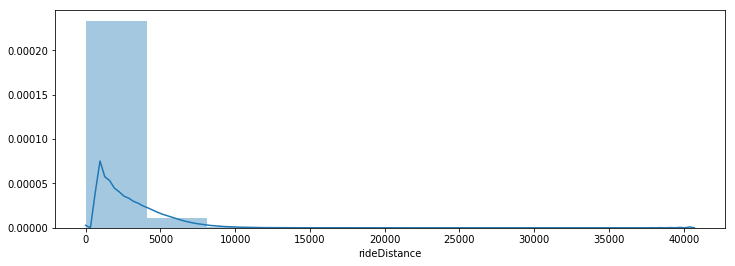

In [66]:
# Plot the distribution of rideDistance
plt.figure(figsize=(12,4))
sns.distplot(df_train['rideDistance'], bins=10)
plt.show()

In [67]:
# rideDistance anomalies
display(df_train[df_train['rideDistance'] >= 20000].shape)
df_train[df_train['rideDistance'] >= 20000].head(10)

(150, 34)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,playersJoined,healsandboosts,totalDistance,killsWithoutMoving,headshot_rate
28588,6260f7c49dc16f,b24589f02eedd7,6ebea3b4f55b4a,0,0,99.20,0,0,1,30,0,1,1,5.419,1894,solo,96,89,1642,0,25930.0,0,0.0,0,0,376.60,6,0,0.6421,96,1,26306.60,False,0.000000
63015,adb7dae4d0c10a,8ede98a241f30a,8b36eac66378e4,0,0,0.00,0,0,0,55,0,0,0,0.000,1891,solo,94,88,1529,0,21880.0,0,0.0,0,0,185.40,0,0,0.5376,94,0,22065.40,False,0.000000
70507,ca6fa339064d67,f7bb2e30c3461f,3bfd8d66edbeff,0,0,100.00,0,0,0,26,0,1,1,3.924,1928,solo,99,95,1512,0,28450.0,1,0.0,0,0,467.50,3,0,0.8878,99,0,28917.50,False,0.000000
72763,198e5894e68ff4,ccf47c82abb11f,d92bf8e696b61d,0,0,0.00,0,0,0,46,0,0,0,0.000,1807,solo-fpp,97,92,1534,0,20510.0,0,0.0,1,0,687.20,9,0,0.7917,97,0,21197.20,False,0.000000
95276,c3fabfce7589ae,15529e25aa4a74,d055504340e5f4,0,7,778.20,0,1,2,2,0,7,2,162.400,1874,solo,94,88,1495,0,25810.0,2,0.0,0,0,923.20,6,0,0.9785,94,9,26733.20,False,0.142857
140097,9944fbbea2b91e,18b4d5f4bb1906,d9d4a3e50cae75,1,0,12.55,0,0,0,53,1270,0,0,0.000,1899,solo-fpp,89,88,-1,0,21230.0,0,0.0,0,0,63.23,0,1514,0.5000,89,0,21293.23,False,0.000000
297186,88904c200175b6,012a61a01e146e,7a270c25e9b70c,0,1,0.00,0,0,1,47,0,0,0,0.000,1919,duo-fpp,48,47,1522,1,28970.0,0,0.0,0,0,297.30,3,0,0.7447,96,2,29267.30,False,0.000000
371098,f7071357f6b762,f3ee20821f4627,ac47c86bf385bf,0,0,72.92,1,0,0,45,0,0,0,0.000,1878,duo-fpp,49,46,1502,0,21700.0,0,0.0,0,0,242.10,4,0,0.6875,96,0,21942.10,False,0.000000
403647,c65da7b3fceef5,814d1b3736e276,ff9f570b555d48,0,2,0.00,0,0,3,54,0,0,0,0.000,1821,duo-fpp,47,46,1527,0,20600.0,0,0.0,0,0,598.20,1,0,0.6739,94,5,21198.20,False,0.000000
426708,149e224a2330ae,6d8cb80b3de8ff,f8b8e2643f60ee,0,2,0.00,0,0,2,43,1120,0,0,0.000,2007,solo,83,83,-1,0,31960.0,0,0.0,0,0,402.10,3,1449,0.8171,83,4,32362.10,False,0.000000


In [17]:
# Remove outliers
df_train.drop(df_train[df_train['rideDistance'] >= 20000].index, inplace=True)

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


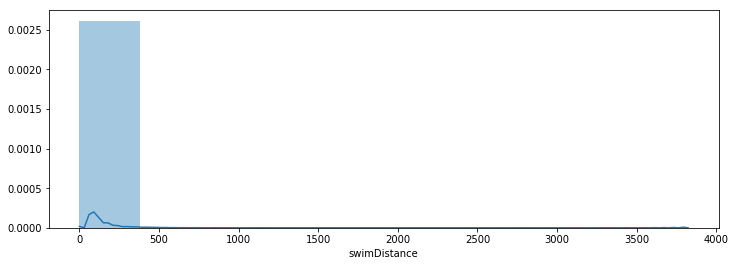

In [69]:
# Plot the distribution of swimDistance
plt.figure(figsize=(12,4))
sns.distplot(df_train['swimDistance'], bins=10)
plt.show()

In [18]:
# Players who swam more than 2 km
df_train[df_train['swimDistance'] >= 2000]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,winPlacePerc,playersJoined,killsNorm,damageDealtNorm,maxPlaceNorm,matchDurationNorm,healsandboosts,totalDistance,killsWithoutMoving,headshot_rate
177973,c2e9e5631f4e54,23213058f83abe,f01eb1073ef377,0,5,78.12,1,0,1,47,...,0.9592,98,0.00,79.6824,51.00,1426.98,6,3297.000,False,0.000000
274258,ba5e3dfb5a0fa0,383db055216ec2,d6e13468e28ab4,0,4,53.32,0,0,16,39,...,0.9600,94,0.00,56.5192,27.56,2319.28,20,10113.000,False,0.000000
1005337,d50c9d0e65fe2a,4996575c11abcb,668402592429f8,0,1,503.00,4,3,1,6,...,1.0000,88,3.36,563.3600,29.12,2124.64,2,10740.000,False,1.000000
1195818,f811de9de80b70,d08ddf7beb6252,8a48703ab52ec8,0,7,352.30,3,1,6,4,...,1.0000,98,5.10,359.3460,49.98,1423.92,13,3083.100,False,0.200000
1227362,a33e917875c80e,5b72674b42712b,5fb0d8b1fc16cf,0,1,589.20,3,1,1,46,...,1.0000,86,2.28,671.6880,13.68,1163.94,2,4818.300,False,0.500000
1889163,bd8cc3083a9923,1d5d17140d6fa4,8e2e6022d6e5c8,0,0,0.00,0,0,0,47,...,0.5833,87,0.00,0.0000,28.25,1567.31,0,5314.000,False,0.000000
2065940,312ccbb27b99aa,47c7f4d69e2fb1,b4b11756321f3a,1,3,49.59,0,0,5,48,...,0.8511,96,0.00,51.5736,49.92,1434.16,8,9899.000,False,0.000000
2327586,8773d0687c6aae,b17f46f9f6666c,56ee5897512c86,3,1,474.40,2,0,0,7,...,1.0000,91,3.27,517.0960,29.43,1318.90,1,2394.546,False,0.000000
2784855,a8653b87e83892,383db055216ec2,d6e13468e28ab4,1,4,843.80,5,5,2,2,...,0.9600,94,7.42,894.4280,27.56,2319.28,6,9926.000,False,0.714286
3359439,3713b36e1ba9e1,1f7aed9240864a,584447ed875c85,0,0,0.00,0,0,0,77,...,0.2143,96,0.00,0.0000,30.16,1426.88,0,4088.000,False,0.000000


In [19]:
# Remove outliers
df_train.drop(df_train[df_train['swimDistance'] >= 2000].index, inplace=True)

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


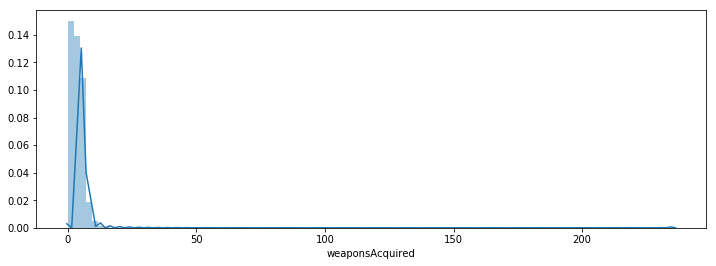

In [72]:
# Plot the distribution of weaponsAcquired
plt.figure(figsize=(12,4))
sns.distplot(df_train['weaponsAcquired'], bins=100)
plt.show()

In [73]:
# Players who acquired more than 80 weapons
display(df_train[df_train['weaponsAcquired'] >= 80].shape)
df_train[df_train['weaponsAcquired'] >= 80].head()

(19, 34)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,playersJoined,healsandboosts,totalDistance,killsWithoutMoving,headshot_rate
233643,7c8c83f5f97d0f,b33b210a52a2f8,2e8a0917a71c43,0,0,67.11,0,0,0,44,1279,0,0,0.0,1901,duo,46,45,-1,0,1880.0,0,0.00,0,0,1307.0,128,1577,0.7111,91,0,3187.00,False,0.000000
588387,c58e3e0c2ba678,3d3e6100c07ff0,d04dbb98249f76,0,1,175.30,1,0,2,48,0,0,0,0.0,1372,squad,29,29,1473,0,0.0,0,0.00,0,0,1687.0,80,0,0.7500,98,3,1687.00,False,0.000000
1437471,8f0c855d23e4cd,679c3316056de8,fbaf1b3ae1d884,1,0,100.00,0,0,0,24,0,1,1,110.6,1840,squad-fpp,29,28,1528,0,2852.0,0,47.21,0,0,2400.0,102,0,0.8929,97,0,5299.21,False,0.000000
1449293,db54cf45b9ed1c,898fccaeeb041d,484b4ae51fe80f,0,0,0.00,0,0,0,54,0,0,0,0.0,1330,squad-fpp,26,23,1442,0,0.0,0,0.00,0,0,653.1,95,0,0.5600,80,0,653.10,False,0.000000
1592744,634a224c53444e,75fa7591d1538c,f900de1ec39fa5,9,0,1726.00,0,3,0,9,0,23,2,48.4,1798,normal-solo-fpp,11,11,1500,0,1908.0,0,0.00,0,0,980.8,94,0,0.2000,11,0,2888.80,False,0.130435


In [20]:
# Remove outliers
df_train.drop(df_train[df_train['weaponsAcquired'] >= 80].index, inplace=True)

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


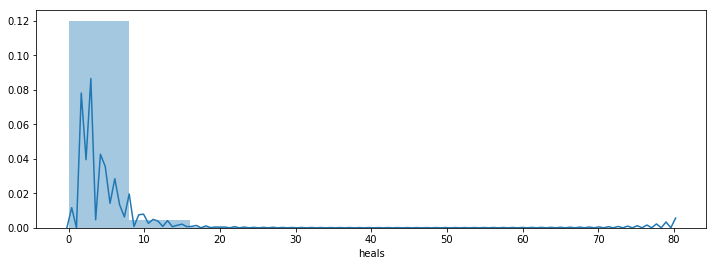

In [75]:
# Distribution of heals
plt.figure(figsize=(12,4))
sns.distplot(df_train['heals'], bins=10)
plt.show()

In [76]:
# 40 or more healing items used
display(df_train[df_train['heals'] >= 40].shape)
df_train[df_train['heals'] >= 40].head(10)

(135, 34)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,playersJoined,healsandboosts,totalDistance,killsWithoutMoving,headshot_rate
18405,63ab976895d860,927eeba5614c4f,69473402649f11,0,2,0.0,0,0,47,43,0,0,0,0.000,1797,solo-fpp,96,92,1527,0,5467.0,0,0.000,0,0,1387.0,6,0,0.9368,96,49,6854.000,False,0.000000
54463,069ddee7c9d26a,58ab5a1ce8e06f,942416b6caf21e,1,4,182.0,0,1,43,21,0,1,1,5.515,1532,squad,27,27,1500,0,0.0,0,292.400,0,0,2791.0,7,0,0.9615,93,47,3083.400,False,1.000000
126439,c45bd6917146e2,81ab9f863957cb,4335664c6716fa,0,2,0.0,0,0,52,49,1331,0,0,0.000,1374,solo-fpp,97,96,-1,0,0.0,0,3.443,0,0,1340.0,3,1543,0.8333,97,54,1343.443,False,0.000000
259351,86910c38335c2f,2738398928d28c,7d2911e944bfaa,0,10,0.0,0,0,42,45,0,0,0,0.000,1769,solo-fpp,97,94,1563,0,5934.0,0,0.000,0,0,1510.0,6,0,0.8646,97,52,7444.000,False,0.000000
268747,a007734fbc6ebf,5bf702dfa1e5d4,ad6b5669d33a2c,0,5,0.0,0,0,48,43,0,0,0,0.000,1878,solo-fpp,93,93,1500,0,3848.0,0,0.000,0,0,1968.0,9,0,0.8370,93,53,5816.000,False,0.000000
269098,a0891dbc2950ea,dde848d90491ba,b4fd3348551b73,0,2,0.0,0,0,42,44,1359,0,0,0.000,1295,squad-fpp,28,28,-1,0,0.0,0,0.000,0,0,2439.0,2,1511,0.9259,97,44,2439.000,False,0.000000
284195,91a2fb00455eb3,f639b09774c5b1,65b73c71653822,0,3,123.0,0,0,40,52,0,0,0,0.000,1965,squad-fpp,30,29,1506,0,2596.0,0,0.000,0,0,2252.0,8,0,0.8276,99,43,4848.000,False,0.000000
300204,1f4f2efc86bfcb,3d668492d1fca9,d3638466a43d38,0,6,175.0,2,1,47,25,1254,1,1,33.310,1358,squad-fpp,32,31,-1,0,487.6,0,0.000,0,0,2928.0,3,1562,0.9355,95,53,3415.600,False,1.000000
349908,7725ad71ad2ff7,4b2a7cf86d1546,cfa2775c9ef944,3,0,2348.0,0,8,41,9,1000,27,3,87.190,1797,normal-solo-fpp,37,22,-1,0,0.0,0,0.000,0,0,268.8,33,1500,0.8889,41,41,268.800,False,0.296296
375156,d64866c78ebcb0,aa0f089ae6430c,4dbc4ebba33ec6,0,7,278.5,3,1,44,3,1034,4,2,35.420,1807,squad,28,25,-1,1,2438.0,0,0.000,0,0,2489.0,6,1517,0.9630,94,51,4927.000,False,0.250000


In [21]:
# Remove outliers
df_train.drop(df_train[df_train['heals'] >= 40].index, inplace=True)

In [23]:
#Removing all null values
df_train.dropna(inplace = True)
df_train.isnull().any().any()

False

In [24]:
df_train.shape

(4444780, 38)

In [26]:
%%time
# Turn groupId, match Id and matchType into categorical types
df_train['groupId'] = df_train['groupId'].astype('category')
df_train['matchId'] = df_train['matchId'].astype('category')
df_train['matchType'] = df_train['matchType'].astype('category')

# Get category coding for groupId and matchID
df_train['groupId_cat'] = df_train['groupId'].cat.codes
df_train['matchId_cat'] = df_train['matchId'].cat.codes
df_train['matchType_cat'] = df_train['matchType'].cat.codes

# Get rid of old columns
df_train.drop(columns=['groupId', 'matchId','matchType'], inplace=True)

# Lets take a look at our newly created features
df_train[['matchType_cat','groupId_cat', 'matchId_cat']].head()

Wall time: 33.4 s


In [27]:
# Drop Id column, because it probably won't be useful for our Machine Learning algorithm,
# because the test set contains different Id's
df_train.drop(columns = ['Id'], inplace=True)

In [28]:
#X = df_train.drop(["Id", "groupId", "matchId", "winPlacePerc"], axis = 1)
x_train = df_train.iloc[:,df_train.columns!='winPlacePerc']
y_train = df_train["winPlacePerc"]

In [29]:
x_train.dtypes

assists                 int64
boosts                  int64
damageDealt           float64
DBNOs                   int64
headshotKills           int64
heals                   int64
killPlace               int64
killPoints              int64
kills                   int64
killStreaks             int64
longestKill           float64
matchDuration           int64
maxPlace                int64
numGroups               int64
rankPoints              int64
revives                 int64
rideDistance          float64
roadKills               int64
swimDistance          float64
teamKills               int64
vehicleDestroys         int64
walkDistance          float64
weaponsAcquired         int64
winPoints               int64
playersJoined           int64
killsNorm             float64
damageDealtNorm       float64
maxPlaceNorm          float64
matchDurationNorm     float64
healsandboosts          int64
totalDistance         float64
killsWithoutMoving       bool
headshot_rate         float64
matchType_

In [30]:
X_train, X_test, y_train, y_test = train_test_split(x_train, y_train, test_size = 0.3, random_state = 0)
print("X_train : " + str(X_train.shape))
print("X_test : " + str(X_test.shape))
print("y_train : " + str(y_train.shape))
print("y_test : " + str(y_test.shape))

X_train : (3111346, 36)
X_test : (1333434, 36)
y_train : (3111346,)
y_test : (1333434,)


In [33]:
# Metric used for the PUBG competition (Mean Absolute Error (MAE))
from sklearn.metrics import mean_absolute_error

# Function to print the MAE (Mean Absolute Error) score
# This is the metric used by Kaggle in this competition
def print_score(m):
    res = ['mae train: ', mean_absolute_error(m.predict(X_train), y_train), 
           'mae val: ', mean_absolute_error(m.predict(X_test), y_test)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [34]:
%%time
from sklearn.ensemble import RandomForestRegressor
m1 = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features='sqrt',
                          n_jobs=-1)
m1.fit(X_train, y_train)
print_score(m1)

['mae train: ', 0.034864059605802494, 'mae val: ', 0.05782879399999455]
Wall time: 14min 23s


In [39]:
%%time
import xgboost as xb
params = {'max_depth':3,
          'gamma':0.3,
          'learning_rate':0.1,
          'n_jobs':-1
         }
xg_model = xb.XGBRegressor(**params)
xg_model.fit(X_train, y_train, early_stopping_rounds = 10, eval_set=[(X_test, y_test)])
print_score(xg_model)

[0]	validation_0-rmse:0.28406
Will train until validation_0-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:0.262549
[2]	validation_0-rmse:0.243454
[3]	validation_0-rmse:0.226876
[4]	validation_0-rmse:0.212213
[5]	validation_0-rmse:0.199449
[6]	validation_0-rmse:0.188456
[7]	validation_0-rmse:0.178586
[8]	validation_0-rmse:0.17018
[9]	validation_0-rmse:0.16276
[10]	validation_0-rmse:0.15654
[11]	validation_0-rmse:0.150985
[12]	validation_0-rmse:0.14626
[13]	validation_0-rmse:0.142107
[14]	validation_0-rmse:0.138694
[15]	validation_0-rmse:0.135471
[16]	validation_0-rmse:0.132831
[17]	validation_0-rmse:0.130152
[18]	validation_0-rmse:0.127941
[19]	validation_0-rmse:0.126016
[20]	validation_0-rmse:0.12419
[21]	validation_0-rmse:0.122387
[22]	validation_0-rmse:0.120943
[23]	validation_0-rmse:0.119727
[24]	validation_0-rmse:0.118514
[25]	validation_0-rmse:0.11756
[26]	validation_0-rmse:0.115715
[27]	validation_0-rmse:0.114602
[28]	validation_0-rmse:0.113128
[29]	validation_0-rmse:0

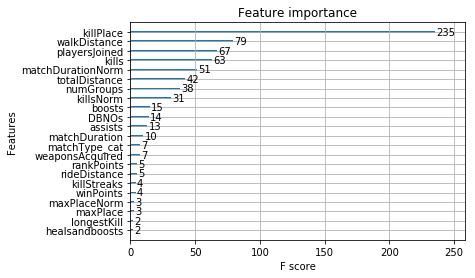

In [40]:
#Plotting important Features
xb.plot_importance(xg_model)

In [53]:
# Add engineered features to the test set
test = df_test.drop(["Id"], axis = 1)
test['playersJoined'] = test.groupby('matchId')['matchId'].transform('count')
test['killsNorm'] = test['kills']*((100-test['playersJoined'])/100 + 1)
test['damageDealtNorm'] = test['damageDealt']*((100-test['playersJoined'])/100 + 1)
test['maxPlaceNorm'] = test['maxPlace']*((100-train['playersJoined'])/100 + 1)
test['matchDurationNorm'] = test['matchDuration']*((100-test['playersJoined'])/100 + 1)
test['healsandboosts'] = test['heals'] + test['boosts']
test['totalDistance'] = test['rideDistance'] + test['walkDistance'] + test['swimDistance']
test['killsWithoutMoving'] = ((test['kills'] > 0) & (test['totalDistance'] == 0))
test['headshot_rate'] = test['headshotKills'] / test['kills']
test['headshot_rate'] = test['headshot_rate'].fillna(0)

# Turn groupId and match Id into categorical types
test['matchType'] = test['matchType'].astype('category')
test['groupId'] = test['groupId'].astype('category')
test['matchId'] = test['matchId'].astype('category')

# Get category coding for groupId and matchID
test['matchType_cat'] = test['matchType'].cat.codes
test['groupId_cat'] = test['groupId'].cat.codes
test['matchId_cat'] = test['matchId'].cat.codes


test.drop(['matchId','matchType','groupId'], axis =1, inplace=True)

In [54]:
test.fillna(0, inplace=True)

In [49]:
test.isnull().any().any()

False

In [52]:
X_train.dtypes

assists                 int64
boosts                  int64
damageDealt           float64
DBNOs                   int64
headshotKills           int64
heals                   int64
killPlace               int64
killPoints              int64
kills                   int64
killStreaks             int64
longestKill           float64
matchDuration           int64
maxPlace                int64
numGroups               int64
rankPoints              int64
revives                 int64
rideDistance          float64
roadKills               int64
swimDistance          float64
teamKills               int64
vehicleDestroys         int64
walkDistance          float64
weaponsAcquired         int64
winPoints               int64
playersJoined           int64
killsNorm             float64
damageDealtNorm       float64
maxPlaceNorm          float64
matchDurationNorm     float64
healsandboosts          int64
totalDistance         float64
killsWithoutMoving       bool
headshot_rate         float64
matchType_

In [55]:
%%time
pred_xg = xg_model.predict(test)
pred_rf = m1.predict(test)

Wall time: 21min 14s


In [56]:
test_id = df_test["Id"]

In [57]:
submit_rf = pd.DataFrame({'Id': test_id, "winPlacePerc": pred_rf} , columns=['Id', 'winPlacePerc'])
print(submit_rf.head())
submit_rf.to_csv("submission_rf.csv", index = False)

               Id  winPlacePerc
0  9329eb41e215eb      0.214803
1  639bd0dcd7bda8      0.905267
2  63d5c8ef8dfe91      0.645051
3  cf5b81422591d1      0.531304
4  ee6a295187ba21      0.901580


In [58]:
submit_xg = pd.DataFrame({'Id': test_id, "winPlacePerc": pred_xg} , columns=['Id', 'winPlacePerc'])
print(submit_xg.head())
submit_xg.to_csv("submission_xg.csv", index = False)

               Id  winPlacePerc
0  9329eb41e215eb      0.208707
1  639bd0dcd7bda8      0.877468
2  63d5c8ef8dfe91      0.564916
3  cf5b81422591d1      0.543767
4  ee6a295187ba21      0.903435
